In [1]:
import gc
import pickle

import numpy as np
import datatable as dt
from tqdm import tqdm

<hr>

# Preprocessing

### Functions

In [105]:
np.random.seed(2020)
def train_test_val_split(df):
    df['train_test'] = np.random.choice([1,2,3], df.nrows, p=[0.8,0.1,0.1])
    
    train = raw[dt.f.train_test==1, dt.f[:-1]]
    test  = raw[dt.f.train_test==2, dt.f[:-1]]
    val   = raw[dt.f.train_test==3, dt.f[:-1]]
    
    return train, test, val

def build_mapping_dict(df, column_definition, disable_progress_bar=False):
    mapping_dict = {}
    ft_ix = 0

    for col, meta in tqdm(column_definition.items(), disable=disable_progress_bar):
        if meta['type'] == 'label': # skip answer
            continue

        if meta['type']=='con':
            mapping_dict[col] = {
                'id': meta['id'],
                'features': ft_ix
            }
            ft_ix += 1

        if meta['type']=='cat':
            unique = list(dt.unique(df[:, dt.f[col]]).to_pandas()[col])
            mapping_dict[col] = {
                'id': meta['id'],
                'features': {ft:ft_ix+i for i,ft in enumerate(unique)}
            }
            ft_ix += len(unique)

    return mapping_dict
            
def datatable_to_ffm(output_file, df, column_definition, mapping_dict, batch_size=10000, disable_progress_bar=False, output_delim=' '):
    # reorder columns
    df = df[:,list(column_definition)]
    
    with open(output_file, 'w') as f:    
        for i in tqdm(range(0, df.nrows, batch_size), disable=disable_progress_bar):

            for row in df[i:i+batch_size,:].to_tuples():
                line = []
                for col, value in zip(column_definition, row):
                    # Skip null values
                    if value is None:
                        continue

                    if column_definition[col]['type']=='label':
                        line.append(str(value))
                    else:
                        if column_definition[col]['type'] == 'cat':
                            try:
                                line.append(f'{column_definition[col]["id"]}:{mapping_dict[col]["features"][value]}:1')
                            except:
                                continue
                        elif column_definition[col]['type']=='con':
                            line.append(f'{column_definition[col]["id"]}:{mapping_dict[col]["features"]}:{value:.5f}')


                line = output_delim.join(line)
                f.write(line)
                f.write('\n')

### Constants

In [113]:
base_dir = '..'
riiid_dir = base_dir + '/riiid_data'

cols_def = {
    'answered_correctly' : {'id':-1, 'type':'label'},
    'timestamp'          : {'id': 0, 'type':'cat'},
    'user_id'            : {'id': 1, 'type':'cat'},
    'content_id'         : {'id': 2, 'type':'cat'},
    'part'               : {'id': 3, 'type':'cat'},
    'content_mean'       : {'id': 4, 'type':'con'},
    'part_mean'          : {'id': 5, 'type':'con'},
    'kmeans_label'       : {'id': 6, 'type':'cat'},
    'kmeans_mean'        : {'id': 7, 'type':'con'},
}

train_data_path = 'xlearn_train.txt'
test_data_path  = 'xlearn_test.txt'
val_data_path   = 'xlearn_val.txt'

mapping_dict_path = 'mapping_dict.pkl'

### Load data

In [62]:
raw = dt.fread(f'{riiid_dir}/train.csv', columns={
    'timestamp':dt.int64,
    'user_id':dt.int32,
    'content_id':dt.int32,
    'content_type_id':dt.bool8,
    'answered_correctly':dt.int32})

raw = raw[dt.f.content_type_id==0, (dt.f.timestamp,
                                    dt.f.user_id,
                                    dt.f.content_id,
                                    dt.int8(dt.f.answered_correctly))]

raw[:,dt.update(timestamp=dt.int32(dt.f.timestamp/3.6e+6))]

In [63]:
# load the kmeans_labels & covert to dataframe
with open(f'{base_dir}/kmeans_labels.pkl', 'rb') as f:
    kmeans_labels = pickle.load(f)

kmeans_labels = dt.Frame({'content_id':list(kmeans_labels.keys()), 'kmeans_label':list(kmeans_labels.values())})
kmeans_labels.names = ('content_id', 'kmeans_label')
kmeans_labels.key = 'content_id'

In [64]:
# Map questions to parts
questions = dt.fread(f'{riiid_dir}/questions.csv')
questions = questions[:, [dt.f.question_id, dt.f.part]]
questions.names = ('content_id', 'part')
questions.key = 'content_id'

# Join kmeans_labels to questions
questions = questions[:,:,dt.join(kmeans_labels)]
questions.key = 'content_id'

### Join questions to dataframe

In [65]:
raw = raw[:,:,dt.join(questions)]

### Train, test, validation split

In [66]:
train, test, val = train_test_val_split(raw)

# 쓰지 않을 df 치우고 메모리 정리
del raw
gc.collect()

102

### Feature Generation

In [67]:
content_means       = train[:,dt.mean(dt.f.answered_correctly), dt.by(dt.f.content_id)]
content_means.names = ('content_id', 'content_mean')
content_means.key   = 'content_id'

part_means       = train[:,dt.mean(dt.f.answered_correctly), dt.by(dt.f.part)]
part_means.names = ('part', 'part_mean')
part_means.key   = 'part'

kmeans_means       = train[:,dt.mean(dt.f.answered_correctly), dt.by(dt.f.kmeans_label)]
kmeans_means.names = ('kmeans_label', 'kmeans_mean')
kmeans_means.key   = 'kmeans_label'

In [68]:
train = train[:,:,dt.join(content_means), dt.join(part_means), dt.join(kmeans_means)]
test = test[:,:,dt.join(content_means), dt.join(part_means), dt.join(kmeans_means)]
val = val[:,:,dt.join(content_means), dt.join(part_means), dt.join(kmeans_means)]

### Handle Nulls

In [69]:
avg_part_mean       = train[:,dt.mean(dt.f.part_mean)].to_numpy()[0][0]
avg_content_id_mean = train[:,dt.mean(dt.f.content_mean)].to_numpy()[0][0]
avg_kmeans_mean     = train[:,dt.mean(dt.f.kmeans_mean)].to_numpy()[0][0]

avg_part_mean, avg_content_id_mean, avg_kmeans_mean

(0.6572752176613474, 0.6572752178101011, 0.6572752180632815)

In [70]:
train[dt.isna(dt.f.part_mean), dt.f.part_mean]       = avg_part_mean
train[dt.isna(dt.f.content_mean), dt.f.content_mean] = avg_content_id_mean
train[dt.isna(dt.f.kmeans_mean), dt.f.kmeans_mean]   = avg_kmeans_mean

test[dt.isna(dt.f.part_mean), dt.f.part_mean]       = avg_part_mean
test[dt.isna(dt.f.content_mean), dt.f.content_mean] = avg_content_id_mean
test[dt.isna(dt.f.kmeans_mean), dt.f.kmeans_mean]   = avg_kmeans_mean

val[dt.isna(dt.f.part_mean), dt.f.part_mean]       = avg_part_mean
val[dt.isna(dt.f.content_mean), dt.f.content_mean] = avg_content_id_mean
val[dt.isna(dt.f.kmeans_mean), dt.f.kmeans_mean]   = avg_kmeans_mean

In [71]:
# # reorder columns
# train = train[:,list(cols_def)]
# test  = test[:,list(cols_def)]
# val   = val[:,list(cols_def)]

### Create Mapping Table

In [100]:
mapping_dict = build_mapping_dict(train, cols_def)

100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


In [101]:
# Save to pickle
with open(mapping_dict_path, 'wb') as f:
    pickle.dump(mapping_dict, f)

### Write Input Files

In [107]:
datatable_to_ffm(train_data_path, train, cols_def, mapping_dict)
datatable_to_ffm(test_data_path, test, cols_def, mapping_dict)
datatable_to_ffm(val_data_path, val, cols_def, mapping_dict)

100%|██████████| 993/993 [00:52<00:00, 18.76it/s]


<hr>

# Train

In [108]:
import xlearn

In [ ]:
model_weight_path = 'model_weight.txt'
model_save_path = 'model_dm.out'

In [114]:
model = xlearn.create_ffm()
model.setTrain(train_data_path)
model.setValidate(val_data_path)
model.setSigmoid()
model.setTXTModel(model_weight_path)

param = {
    'task':'binary',
    'lr':0.2,
    'metric':'auc',
    'epoch':10,
    'opt': 'adagrad',
    'nthread':7,
    'lambda':0.0002,
    'k':4
}

model.fit(param, model_save_path)

<hr>

# Test

In [123]:
import time
import sklearn.metrics
import matplotlib.pyplot as plt

In [116]:
result_file_path = 'res.txt'

In [127]:
model = xlearn.create_ffm()
model.setTest(test_data_path)
model.setSigmoid()

s = time.time()

model.predict(model_save_path, result_file_path)

print(time.time()-s)

5.160456657409668


### Test model performance

In [128]:
true = []
with open(test_data_path) as f:
    for line in f:
        true.append(int(float(line.split()[0])))

res = []
with open(result_file_path) as f:
    for line in f:
        res.append(float(line[:-1]))

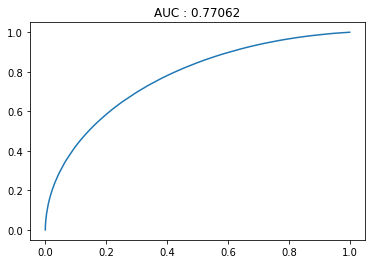

In [129]:
fpr, tpr, _ = sklearn.metrics.roc_curve(true,  res)
auc = sklearn.metrics.roc_auc_score(true,  res)

plt.plot(fpr,tpr)
plt.title(f'AUC : {auc:.5f}')
plt.show()